
# Improving Forecasting Performance
# Step1- data improvement 

In [ ]:
# import necessary libraries
import numpy as np # linear algebra
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')  # Hide warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
from plotnine import *
import io
# we'll use the statistics package to conduct some predictive analytics
import statistics as st
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from  sklearn.metrics import mean_absolute_error

In [ ]:
# Python
df = pd.read_csv('/content/drive/MyDrive/prophet_data/Used_Data/wp_peyton_manning.csv')
df

,ds,y
0,2007-12-10,14629
1,2007-12-11,5012
2,2007-12-12,3582
3,2007-12-13,3205
4,2007-12-14,2680
...,...,...
2900,2016-01-16,2483
2901,2016-01-17,10656
2902,2016-01-18,30754
2903,2016-01-19,9190


In [ ]:
## function to Plot the data

def _fig_plot(df, X, Y):
  ''' Function plots the data. requires to provide dataframe in the
  format of date as ds, observation as y, Preset other variables e.g., axis name
  '''
  df.plot(x = X, y = Y, figsize=Figsize, label = Label)
  plt.xlabel(xAxisLabel, fontsize = 16) # matplotlib.pyplot
  plt.ylabel(yAxisLabel, fontsize = 16)
  plt.legend()
  plt.title(Title, fontsize = 20)
  ax = plt.gca().get_xaxis()

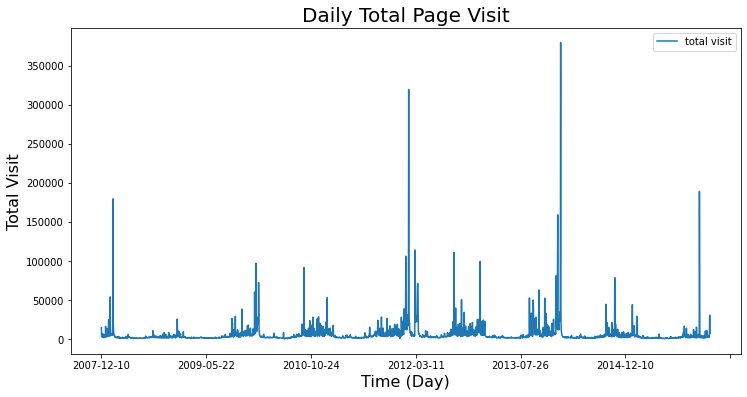

In [ ]:
# provide variable names and other required inputs to plot using the function
X = 'ds'
Y = 'y'
Label = "total visit"
Figsize = (12,6)
Title = "Daily Total Page Visit"
xAxisLabel = 'Time (Day)'
yAxisLabel = 'Total Visit'
_fig_plot(df, X, Y)

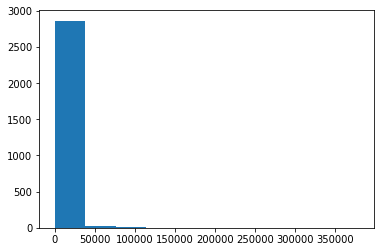

In [ ]:
plt.hist(df.y)
plt.show()

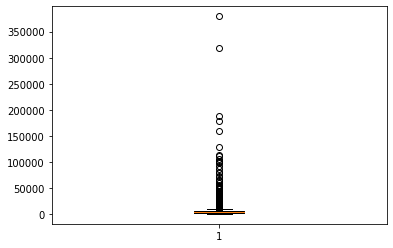

In [ ]:
plt.boxplot(df.y)
plt.show()

### skewness reduction


In [ ]:
df_raw = df.copy()
df['y'] = np.log(df['y'])

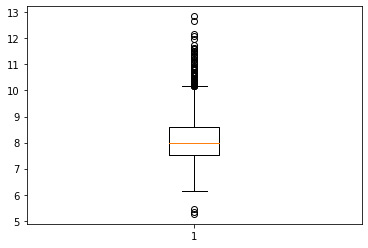

In [ ]:
plt.boxplot(df.y.values)
plt.show()

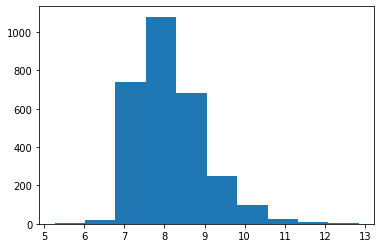

In [ ]:
plt.hist(df.y)
plt.show()

In [ ]:
df_log = df.copy() # keep a copy of log converted df

### outliers detection

In [ ]:
# outlier detection using inter quartile range
Q1=df.y.quantile(0.25)
Q3=df.y.quantile(0.75)
IQR = Q3-Q1
LT=Q1-1.5*IQR
HT= Q3+1.5*IQR
print(LT, HT)
df['outlier']=np.where(((df['y']<LT)|(df['y']>HT)),'yes','no')

5.9167474153552355 10.17822033571106


alternative statistical approach:
using mean/median absolute deviation

In [ ]:
df['outlier'].value_counts()

no     2827
yes      78
Name: outlier, dtype: int64

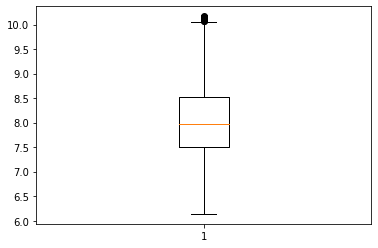

In [ ]:
plt.boxplot(df[df.outlier=='no'].y)
plt.show()

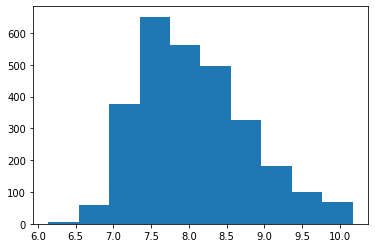

In [ ]:
plt.hist(df[df.outlier=='no'].y)
plt.show()

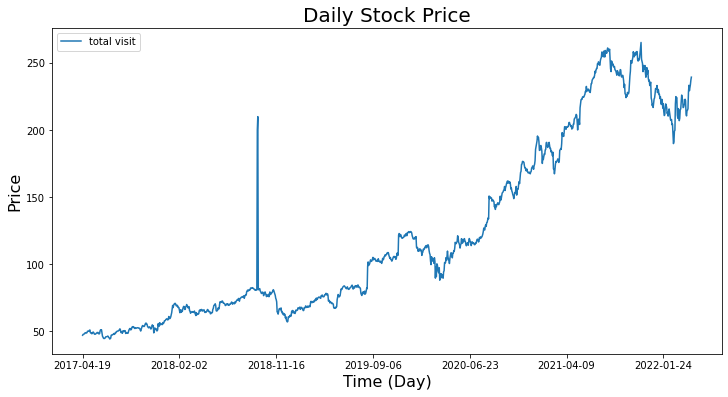

In [ ]:
# advanced and better approach for time series outlier removal
df_stock = pd.read_csv('/content/drive/MyDrive/prophet_data/Used_Data/TTT_outlier.csv')
Title = "Daily Stock Price"
xAxisLabel = 'Time (Day)'
yAxisLabel = 'Price'
_fig_plot(df_stock, 'Date', 'Adj Close')

In [ ]:
df_stock.shape

(1259, 7)

In [ ]:
# moving average based statistics
df_stock['SMA'] = df_stock['Adj Close'].rolling(window=5).mean()
df_stock['diff'] = df_stock['Adj Close'] - df_stock['SMA']
df_stock

,Date,Open,High,Low,Close,Adj Close,Volume,SMA,diff
0,2017-04-19,53.790001,54.380001,53.709999,53.889999,47.106853,5419600,NaN,NaN
1,2017-04-20,54.209999,54.880001,54.110001,54.639999,47.762440,5843200,NaN,NaN
2,2017-04-21,54.540001,55.130001,54.540001,54.779999,47.884815,5948300,NaN,NaN
3,2017-04-24,55.160000,55.290001,54.419998,54.820000,47.919788,5717900,NaN,NaN
4,2017-04-25,54.900002,55.160000,54.799999,55.150002,48.208248,4096700,47.776429,0.431819
...,...,...,...,...,...,...,...,...,...
1254,2022-04-11,233.259995,235.960007,228.910004,229.309998,229.309998,3172200,224.313998,4.996000
1255,2022-04-12,232.300003,235.410004,230.389999,231.339996,231.339996,3366600,227.623999,3.715997
1256,2022-04-13,230.300003,235.190002,229.509995,233.820007,233.820007,2451300,231.200000,2.620007
1257,2022-04-14,233.910004,238.190002,233.110001,237.199997,237.199997,3909300,233.001999,4.197998


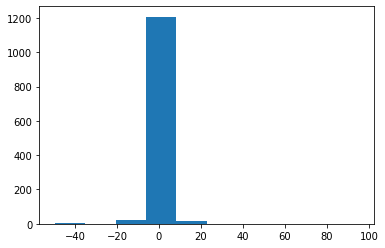

In [ ]:
plt.hist(df_stock['diff'])
plt.show()

In [ ]:
df_stock['diff'].describe()

count    1255.000000
mean        0.301223
std         5.084669
min       -49.642884
25%        -0.769394
50%         0.244533
75%         1.255495
max        95.313519
Name: diff, dtype: float64

In [ ]:
# ML based approach
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=30, contamination=0.01)
df_stock['outlier_sk'] = clf.fit_predict(df_stock['Open'].values.reshape(-1,1),df_stock['Adj Close'].values.reshape(-1,1))
df_stock.outlier_sk.value_counts()

 1    1246
-1      13
Name: outlier_sk, dtype: int64

### outliers treatment

In [ ]:
#Quantile-based Flooring and Capping
print(df['y'].quantile(0.10))
print(df['y'].quantile(0.90))

7.246653081895779
9.22684277510563


In [ ]:

df.loc[(df['outlier']=='yes'), 'y'] = None
df

,ds,y,outlier
0,2007-12-10,9.590761,no
1,2007-12-11,8.519590,no
2,2007-12-12,8.183677,no
3,2007-12-13,8.072467,no
4,2007-12-14,7.893572,no
...,...,...,...
2900,2016-01-16,7.817223,no
2901,2016-01-17,9.273878,no
2902,2016-01-18,NaN,yes
2903,2016-01-19,9.125871,no


In [ ]:
# okay to do - missing value imputation
df.fillna(method='ffill', inplace=False)

,ds,y,outlier
0,2007-12-10,9.590761,no
1,2007-12-11,8.519590,no
2,2007-12-12,8.183677,no
3,2007-12-13,8.072467,no
4,2007-12-14,7.893572,no
...,...,...,...
2900,2016-01-16,7.817223,no
2901,2016-01-17,9.273878,no
2902,2016-01-18,9.273878,yes
2903,2016-01-19,9.125871,no


In [ ]:
# NOT TO DO
df.dropna() # drop the dates too
df.y.fillna(df.y.mean()) # does not work for time series

0       9.590761
1       8.519590
2       8.183677
3       8.072467
4       7.893572
          ...   
2900    7.817223
2901    9.273878
2902    8.071337
2903    9.125871
2904    8.891374
Name: y, Length: 2905, dtype: float64

### suggestion: Keep the missing value as it is or the outliers as null values

# Performance comparison

### forecasting with unprocessed raw data

22:53:16 - cmdstanpy - INFO - Chain [1] start processing
22:53:17 - cmdstanpy - INFO - Chain [1] done processing


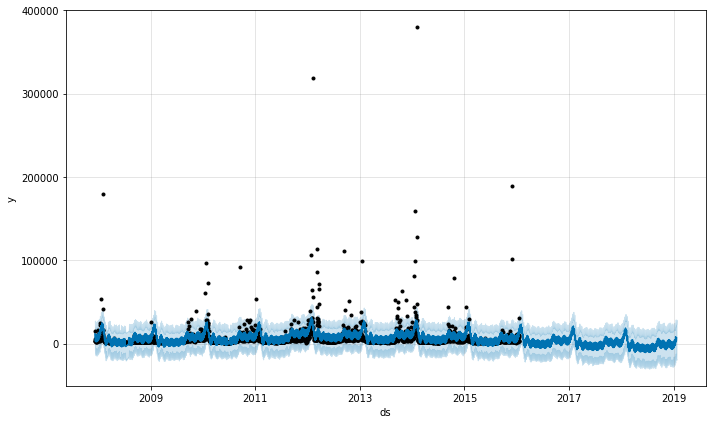

In [ ]:
# Prophet fitted with raw data
m = Prophet()
m.fit(df_raw)
future = m.make_future_dataframe(periods=1096)
forecast = m.predict(future)
fig = m.plot(forecast)
plt.show()

In [ ]:
evaluation_model = cross_validation(m, initial='730 days', period='180 days', horizon = '30 days')
evaluation_metrix = performance_metrics(evaluation_model)
evaluation_metrix.head(5)

  0%|          | 0/13 [00:00<?, ?it/s]

22:31:05 - cmdstanpy - INFO - Chain [1] start processing
22:31:05 - cmdstanpy - INFO - Chain [1] done processing
22:31:07 - cmdstanpy - INFO - Chain [1] start processing
22:31:07 - cmdstanpy - INFO - Chain [1] done processing
22:31:08 - cmdstanpy - INFO - Chain [1] start processing
22:31:09 - cmdstanpy - INFO - Chain [1] done processing
22:31:10 - cmdstanpy - INFO - Chain [1] start processing
22:31:10 - cmdstanpy - INFO - Chain [1] done processing
22:31:12 - cmdstanpy - INFO - Chain [1] start processing
22:31:12 - cmdstanpy - INFO - Chain [1] done processing
22:31:14 - cmdstanpy - INFO - Chain [1] start processing
22:31:14 - cmdstanpy - INFO - Chain [1] done processing
22:31:15 - cmdstanpy - INFO - Chain [1] start processing
22:31:15 - cmdstanpy - INFO - Chain [1] done processing
22:31:17 - cmdstanpy - INFO - Chain [1] start processing
22:31:17 - cmdstanpy - INFO - Chain [1] done processing
22:31:19 - cmdstanpy - INFO - Chain [1] start processing
22:31:19 - cmdstanpy - INFO - Chain [1]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,4 days,1.848212e+08,13594.894437,5241.910889,1.021591,0.955536,0.807426,0.945344
1,5 days,2.038085e+08,14276.149883,5972.287142,0.978462,0.852495,0.798254,0.894737
2,6 days,2.043120e+08,14293.774318,6120.191108,1.071146,0.934114,0.869622,0.868421
3,7 days,6.009424e+07,7752.047153,4954.249266,1.300213,0.911853,0.900528,0.868421
4,8 days,2.480207e+08,15748.672242,7011.977508,1.529243,0.885595,0.985600,0.868421


remarks: messed up trends and seasonalities with high mape

### forecasting with log-converted data

22:31:30 - cmdstanpy - INFO - Chain [1] start processing
22:31:30 - cmdstanpy - INFO - Chain [1] done processing


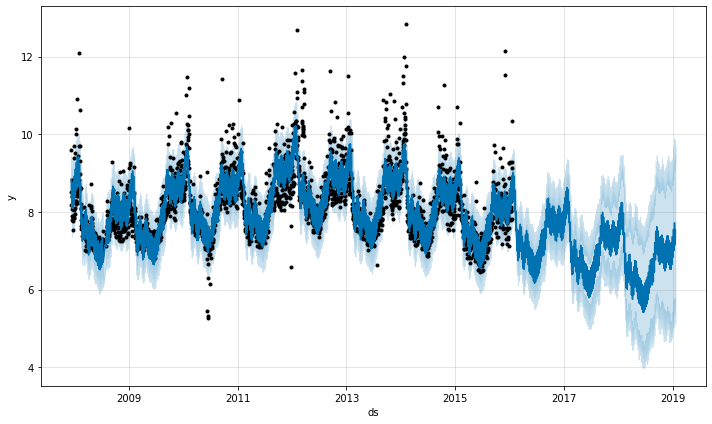

In [ ]:
# prophet fitted with less skewed data
m = Prophet()
m.fit(df_log)
future = m.make_future_dataframe(periods=1096)
forecast = m.predict(future)
fig = m.plot(forecast)
plt.show()

In [ ]:
evaluation_model = cross_validation(m, initial='730 days', period='180 days', horizon = '30 days')
evaluation_metrix = performance_metrics(evaluation_model)
evaluation_metrix.head(5)

  0%|          | 0/13 [00:00<?, ?it/s]

22:31:35 - cmdstanpy - INFO - Chain [1] start processing
22:31:35 - cmdstanpy - INFO - Chain [1] done processing
22:31:37 - cmdstanpy - INFO - Chain [1] start processing
22:31:37 - cmdstanpy - INFO - Chain [1] done processing
22:31:38 - cmdstanpy - INFO - Chain [1] start processing
22:31:39 - cmdstanpy - INFO - Chain [1] done processing
22:31:40 - cmdstanpy - INFO - Chain [1] start processing
22:31:40 - cmdstanpy - INFO - Chain [1] done processing
22:31:42 - cmdstanpy - INFO - Chain [1] start processing
22:31:42 - cmdstanpy - INFO - Chain [1] done processing
22:31:44 - cmdstanpy - INFO - Chain [1] start processing
22:31:44 - cmdstanpy - INFO - Chain [1] done processing
22:31:46 - cmdstanpy - INFO - Chain [1] start processing
22:31:46 - cmdstanpy - INFO - Chain [1] done processing
22:31:48 - cmdstanpy - INFO - Chain [1] start processing
22:31:48 - cmdstanpy - INFO - Chain [1] done processing
22:31:50 - cmdstanpy - INFO - Chain [1] start processing
22:31:50 - cmdstanpy - INFO - Chain [1]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,4 days,0.297400,0.545344,0.395284,0.046858,0.034373,0.047450,0.761134
1,5 days,0.355086,0.595891,0.465639,0.054584,0.046224,0.054941,0.710526
2,6 days,0.364899,0.604068,0.473654,0.055003,0.048037,0.055129,0.710526
3,7 days,0.335283,0.579036,0.469513,0.055026,0.048943,0.054996,0.684211
4,8 days,0.425749,0.652495,0.481167,0.054572,0.046466,0.055342,0.657895


### forecasting with outlier treated data

22:32:01 - cmdstanpy - INFO - Chain [1] start processing
22:32:01 - cmdstanpy - INFO - Chain [1] done processing


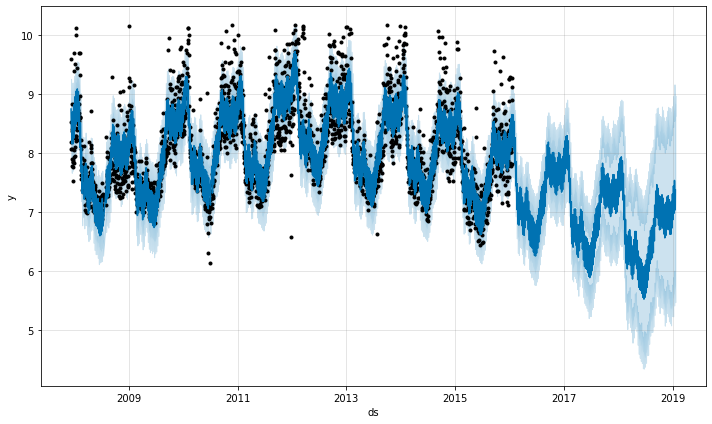

In [ ]:
# prophet fitted with less skewed data
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=1096)
forecast = m.predict(future)
fig = m.plot(forecast)
plt.show()

In [ ]:
evaluation_model = cross_validation(m, initial='730 days', period='180 days', horizon = '30 days')
evaluation_metrix = performance_metrics(evaluation_model)
evaluation_metrix.head(5)

  0%|          | 0/13 [00:00<?, ?it/s]

22:32:06 - cmdstanpy - INFO - Chain [1] start processing
22:32:06 - cmdstanpy - INFO - Chain [1] done processing
22:32:08 - cmdstanpy - INFO - Chain [1] start processing
22:32:08 - cmdstanpy - INFO - Chain [1] done processing
22:32:10 - cmdstanpy - INFO - Chain [1] start processing
22:32:10 - cmdstanpy - INFO - Chain [1] done processing
22:32:11 - cmdstanpy - INFO - Chain [1] start processing
22:32:11 - cmdstanpy - INFO - Chain [1] done processing
22:32:13 - cmdstanpy - INFO - Chain [1] start processing
22:32:13 - cmdstanpy - INFO - Chain [1] done processing
22:32:15 - cmdstanpy - INFO - Chain [1] start processing
22:32:15 - cmdstanpy - INFO - Chain [1] done processing
22:32:17 - cmdstanpy - INFO - Chain [1] start processing
22:32:17 - cmdstanpy - INFO - Chain [1] done processing
22:32:19 - cmdstanpy - INFO - Chain [1] start processing
22:32:19 - cmdstanpy - INFO - Chain [1] done processing
22:32:21 - cmdstanpy - INFO - Chain [1] start processing
22:32:21 - cmdstanpy - INFO - Chain [1]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,0.139393,0.373354,0.280514,0.034566,0.021836,0.034885,0.775824
1,4 days,0.146680,0.382989,0.301484,0.037791,0.033452,0.037881,0.714286
2,5 days,0.167160,0.408853,0.343252,0.043413,0.037773,0.043100,0.680952
3,6 days,0.181400,0.425911,0.357876,0.044397,0.037773,0.043966,0.702381
4,7 days,0.201771,0.449189,0.376054,0.045599,0.043715,0.045392,0.657143
